In [80]:
import requests
import json
from bs4 import BeautifulSoup
import lxml
import pandas as pd
from highlight_text import fig_text
from mplsoccer import VerticalPitch,Pitch
import matplotlib.pyplot as plt
pd.set_option('mode.chained_assignment', None)
import seaborn as sns
from adjustText import adjust_text
from urllib.request import urlopen
import matplotlib as mpl
from PIL import Image
from mplsoccer import Pitch, add_image
plt.style.use('default')
import matplotlib.font_manager as fm
import os

In [81]:
url = "https://understat.com/team/Manchester_City/2022"
r = requests.get(url)
soup = BeautifulSoup(r.content, 'lxml')
scripts = soup.find_all('script')
strings = scripts[1].string
ind_start = strings.index("('")+2
ind_end = strings.index("')")
json_data = strings[ind_start:ind_end]
json_data = json_data.encode('utf8').decode('unicode_escape')
json_data = json.loads(json_data)

In [82]:
MatchesPlayed = [json_data[i]["id"] for i in range(len(json_data)) if json_data[i]["isResult"] == True]

In [83]:
MatchesPlayed

['18211', '18214', '18230', '18237', '18246', '18258']

In [84]:
summary = pd.DataFrame()

for i in MatchesPlayed:
    url = f"https://understat.com/match/{i}"
    r = requests.get(url)
    soup = BeautifulSoup(r.content, 'lxml')
    scripts = soup.find_all('script')
    strings = scripts[1].string
    ind_start = strings.index("('")+2
    ind_end = strings.index("')")
    json_data = strings[ind_start:ind_end]
    json_data = json_data.encode('utf8').decode('unicode_escape')
    json_data = json.loads(json_data)

    title = soup.find_all('a')
    title = title[5].text

    HomeTeam = json_data["h"][0]["h_team"]
    AwayTeam = json_data["h"][0]["a_team"]

    date = pd.to_datetime(json_data['h'][0]['date'])
    date = f"{date.day} {date.month_name()} {date.year}"

    if HomeTeam == "Manchester City":
        print(f"{title} - {HomeTeam} VS {AwayTeam} ({date}) (H) : {url}")
    else:
        print(f"{title} - {HomeTeam} VS {AwayTeam} ({date}) (A) : {url}")
    
    h_minutes = [json_data['h'][i]['minute'] for i in range(len(json_data['h']))]
    h_X = [json_data['h'][i]['X'] for i in range(len(json_data['h']))]
    h_Y = [json_data['h'][i]['Y'] for i in range(len(json_data['h']))]
    h_xG = [json_data['h'][i]['xG'] for i in range(len(json_data['h']))]
    h_player_name = [json_data['h'][i]['player'] for i in range(len(json_data['h']))]
    h_assisted_by = [json_data['h'][i]['player_assisted'] for i in range(len(json_data['h']))]
    h_player_id = [json_data['h'][i]['player_id'] for i in range(len(json_data['h']))]
    h_player_team = [json_data['h'][i]['h_team'] for i in range(len(json_data['h']))]
    h_situation = [json_data['h'][i]['situation'] for i in range(len(json_data['h']))]
    h_result = [json_data['h'][i]['result'] for i in range(len(json_data['h']))]
    h_last_action = [json_data['h'][i]['lastAction'] for i in range(len(json_data['h']))]

    df_home = pd.DataFrame({'Minute':h_minutes,'X':h_X,'Y':h_Y,'xG':h_xG,'Player':h_player_name,'player_id':h_player_id,'Assist':h_assisted_by,'Home Team':h_player_team,'Situation':h_situation,"Last action":h_last_action,'Output':h_result})

    df_home['Minute'] = df_home['Minute'].astype(int)
    df_home['X'] = df_home['X'].astype(float).round(2)
    df_home['Y'] = df_home['Y'].astype(float).round(2)
    df_home['xG'] = df_home['xG'].astype(float).round(2)
    df_home['Minute'] = df_home['Minute'].astype(int)

    df_home.Output.replace(['MissedShots','SavedShot', 'BlockedShot','ShotOnPost','OwnGoal'],
                        ['Missed Shot','Saved Shot', 'Blocked Shot', 'Shot On Post','Own Goal'],inplace=True)
    df_home['Situation'].replace(['OpenPlay','DirectFreekick','FromCorner','SetPiece'],
                                ['Open Play','Direct Free kick','From Corner','Set Piece'] ,inplace=True)

    df_home['Last action'].replace(['BallRecovery', 'TakeOn','Throughball','LayOff', 'HeadPass','BallTouch','BlockedPass'],
                                ['Ball Recovery', 'Take On','Through ball','Lay Off', 'Head Pass','Ball Touch','Blocked Pass'],inplace=True)

    for i in range(len(df_home)):
        df_home['X'][i] = df_home['X'][i]*120 - 0.3
        df_home['Y'][i] = abs(df_home['Y'][i]*80 - 80)

    home_team = df_home['Home Team'].unique()[0]
    home_score = df_home[df_home['Output'] == 'Goal'].shape[0]
    home_score_xg = df_home['xG'].sum()
    home_score_xg = round(home_score_xg,2)

    a_minutes = [json_data['a'][i]['minute'] for i in range(len(json_data['a']))]
    a_X = [json_data['a'][i]['X'] for i in range(len(json_data['a']))]
    a_Y = [json_data['a'][i]['Y'] for i in range(len(json_data['a']))]
    a_xG = [json_data['a'][i]['xG'] for i in range(len(json_data['a']))]
    a_player_name = [json_data['a'][i]['player'] for i in range(len(json_data['a']))]
    a_assisted_by = [json_data['a'][i]['player_assisted'] for i in range(len(json_data['a']))]
    a_player_id = [json_data['a'][i]['player_id'] for i in range(len(json_data['a']))]
    a_player_team = [json_data['a'][i]['a_team'] for i in range(len(json_data['a']))]
    a_situation = [json_data['a'][i]['situation'] for i in range(len(json_data['a']))]
    a_result = [json_data['a'][i]['result'] for i in range(len(json_data['a']))]
    a_last_action = [json_data['a'][i]['lastAction'] for i in range(len(json_data['a']))]


    df_away = pd.DataFrame({'Minute':a_minutes,'X':a_X,'Y':a_Y,'xG':a_xG,'Player':a_player_name,'Assist':a_assisted_by,'player_id':a_player_id,'Away Team':a_player_team,'Situation':a_situation,'Last action':a_last_action,'Output':a_result})

    df_away['Minute'] = df_away['Minute'].astype(int)
    df_away['X'] = df_away['X'].astype(float).round(2)
    df_away['Y'] = df_away['Y'].astype(float).round(2)
    df_away['xG'] = df_away['xG'].astype(float).round(2)
    df_away['Minute'] = df_away['Minute'].astype(int)

    for i in range(len(df_away)):
        df_away['X'][i] = df_away['X'][i]*120 - 0.3
        df_away['Y'][i] = abs(df_away['Y'][i]*80-80)

    df_away.Output.replace(['MissedShots','SavedShot', 'BlockedShot','ShotOnPost','OwnGoal'],
                        ['Missed Shot','Saved Shot', 'Blocked Shot', 'Shot On Post',"Own Goal"],inplace=True)
    df_away['Situation'].replace(['OpenPlay','DirectFreekick','FromCorner','SetPiece'], 
                                ['Open Play','Direct Free kick','From Corner','Set Piece'] ,inplace=True)

    df_away['Last action'].replace(['BallRecovery', 'TakeOn','Throughball','LayOff', 'HeadPass','BallTouch','BlockedPass'],
                                ['Ball Recovery', 'Take On','Through ball','Lay Off', 'Head Pass','Ball Touch','Blocked Pass'],inplace=True)
        

    """""df['Shot type'].replace(['LeftFoot', 'RightFoot','OtherBodyPart'],
                                ['Left Foot','Right Foot' ,'Other Body Part'] ,inplace=True)"""""


    away_team = df_away['Away Team'].unique()[0]
    away_score = df_away[df_away['Output'] == 'Goal'].shape[0]
    away_score_xg = df_away['xG'].sum()
    away_score_xg = round(away_score_xg,2)


    if "OwnGoal" in df_away.Output.values:
        home_score += 1
        
        if "OwnGoal" in df_home.Output.values:
            away_score += 1

    Leagues = {'Ligue 1':"Ligue 1 uber eats",
        'EPL':"Premier League",
        'Serie A':"Serie A TIM",
        'La liga':"LaLiga Santander",
        'Bundesliga':"Bundesliga"}

    Leagues_logos = {'Ligue 1':r"C:\Users\Administrator\Desktop\DataVizMaterial\Leagues logos\Logo_Ligue_1_Uber_Eats_2020.svg.png",
        'EPL':r"C:\Users\Administrator\Desktop\DataVizMaterial\Leagues logos\Premier-League-PNG-Image.png",
        'Serie A':r"C:\Users\Administrator\Desktop\DataVizMaterial\Leagues logos\se1113l151-serie-a-logo-lega-serie-a-european-leagues.png",
        'La liga':r"C:\Users\Administrator\Desktop\DataVizMaterial\Leagues logos\6893566_preview.png",
        'Bundesliga':r"C:\Users\Administrator\Desktop\DataVizMaterial\Leagues logos\bundesliga-home-events.png"}

    if title in Leagues_logos.keys():
            league = Leagues[title]
            league_logo = Leagues_logos[title]
            #print(league,": ",league_logo)

    for root,dirs,files in os.walk(r"C:\Users\Administrator\Desktop\DataVizMaterial\club badges"):
        for file in files:
            try:
                if file.startswith(f'{home_team}'):
                    #print(os.path.join(root,file))
                    HomeTeamLogo_ = os.path.join(root,file)
                
                if file.startswith(f'{away_team}'):
                    #print(os.path.join(root,file))
                    AwayTeamLogo_ = os.path.join(root,file)
            
            except:
                print('Photo not found')
                break    


    if away_team == "Manchester City" :
        summary = pd.concat([summary,df_away],axis=0)
        
    elif home_team == "Manchester City":
            summary = pd.concat([summary,df_home],axis=0)

EPL - West Ham VS Manchester City (7 August 2022) (A) : https://understat.com/match/18211
EPL - Manchester City VS Bournemouth (13 August 2022) (H) : https://understat.com/match/18214
EPL - Newcastle United VS Manchester City (21 August 2022) (A) : https://understat.com/match/18230
EPL - Manchester City VS Crystal Palace (27 August 2022) (H) : https://understat.com/match/18237
EPL - Manchester City VS Nottingham Forest (31 August 2022) (H) : https://understat.com/match/18246
EPL - Aston Villa VS Manchester City (3 September 2022) (A) : https://understat.com/match/18258


In [85]:
 PlayerTeam = summary['Away Team'].values[0]

In [86]:
PlayerTeam

'Manchester City'

In [87]:
PlayerName = input("Please, Enter the name of the player: ")

In [88]:
summary = summary[(summary.Player == PlayerName)]
summary.reset_index(inplace=True,drop=True)

In [89]:
summary

,Minute,X,Y,xG,Player,Assist,player_id,Away Team,Situation,Last action,Output,Home Team
0,38,87.3,45.6,0.05,Ilkay Gündogan,None,314,Manchester City,Direct Free kick,Standard,Blocked Shot,NaN
1,61,113.7,31.2,0.09,Ilkay Gündogan,Kevin De Bruyne,314,Manchester City,Open Play,Cross,Missed Shot,NaN
2,18,107.7,36.0,0.42,Ilkay Gündogan,Erling Haaland,314,NaN,Open Play,Pass,Goal,Manchester City
3,59,93.3,45.6,0.03,Ilkay Gündogan,Riyad Mahrez,314,NaN,Open Play,Pass,Missed Shot,Manchester City
4,4,110.1,37.6,0.36,Ilkay Gündogan,Bernardo Silva,314,Manchester City,Open Play,Chipped,Goal,NaN
5,36,104.1,36.8,0.08,Ilkay Gündogan,None,314,Manchester City,Open Play,None,Blocked Shot,NaN
6,59,102.9,29.6,0.04,Ilkay Gündogan,Rúben Dias,314,Manchester City,From Corner,Ball Touch,Blocked Shot,NaN
7,84,110.1,35.2,0.05,Ilkay Gündogan,Kevin De Bruyne,314,NaN,Open Play,Aerial,Saved Shot,Manchester City
8,2,90.9,48.0,0.02,Ilkay Gündogan,Rodri,314,NaN,Open Play,Pass,Missed Shot,Manchester City
9,45,88.5,44.0,0.03,Ilkay Gündogan,Julián Álvarez,314,NaN,Open Play,Lay Off,Missed Shot,Manchester City


In [90]:
summary[summary.Output=='Goal']

,Minute,X,Y,xG,Player,Assist,player_id,Away Team,Situation,Last action,Output,Home Team
2,18,107.7,36.0,0.42,Ilkay Gündogan,Erling Haaland,314,NaN,Open Play,Pass,Goal,Manchester City
4,4,110.1,37.6,0.36,Ilkay Gündogan,Bernardo Silva,314,Manchester City,Open Play,Chipped,Goal,NaN


In [91]:
Shots = len(summary)
SavedShots = len(summary[summary.Output=='Saved Shot'])
Goals = len(summary[summary.Output=='Goal'])
ShotsOnTarget = len(summary[(summary.Output !='Blocked Shot') & (summary.Output != 'Missed Shot') & (summary.Output != 'Own Goal')])

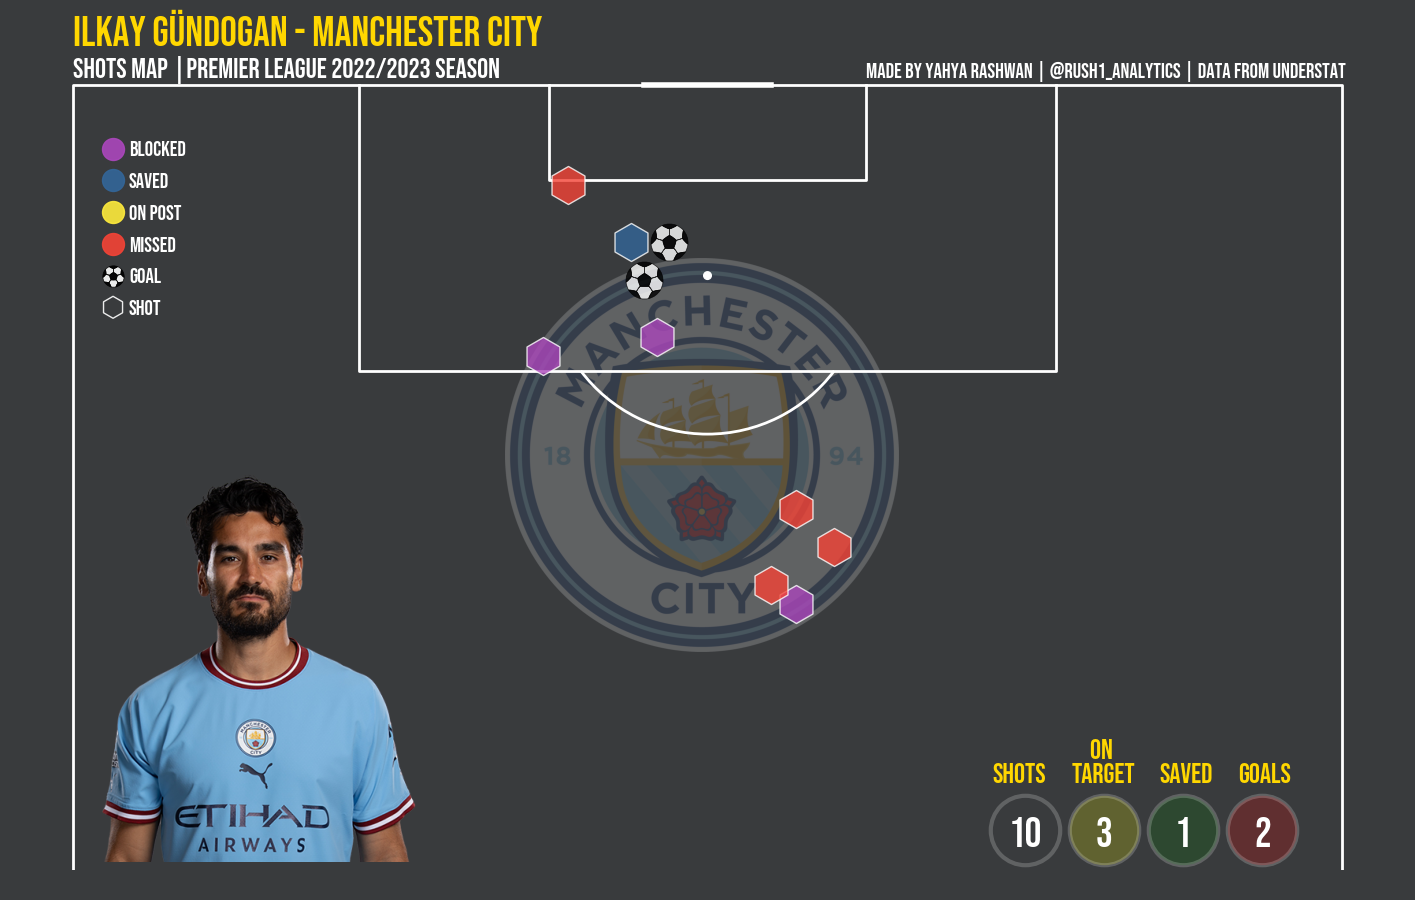

In [95]:
background = '#393b3d'
text_color = 'white'

mpl.rcParams['xtick.color']=text_color
mpl.rcParams['ytick.color']=text_color
mpl.rcParams['axes.labelcolor']='black'
mpl.rcParams['text.color']=text_color
mpl.rcParams['legend.fontsize'] = 15


path = r"D:\Downloads\Downloads\1d8761b0-9410-11e9-ba67-ebab80fd2244.otf"
fontprop = fm.FontProperties(fname=path, size=30, weight='bold', style='normal', stretch='normal')
fontprop2 = fm.FontProperties(fname=path, size=10*2, weight='bold', style='normal', stretch='normal')
fontprop3 = fm.FontProperties(fname=path, size=5*3, weight='bold', style='normal', stretch='normal')

pitch = VerticalPitch( half=True,goal_type='line',line_color='white',pad_bottom=-10.5,linewidth=2)
fig, ax = plt.subplots(figsize=(6*3,4*3))
ax.axis('off')

fig.patch.set_color(background)
pitch.draw(ax=ax)

for i in range(len(summary)):
    if summary.Output[i] == 'Goal':
        pitch.scatter(ax=ax,x=summary['X'][i],y=summary['Y'][i],c="white",s=750,alpha=0.8,marker='football',edgecolors='black')
    elif summary.Output[i] == 'Blocked Shot':
        pitch.scatter(ax=ax,x=summary['X'][i],y=summary['Y'][i],c="#AB47BC",s=750,alpha=0.8,marker='h',edgecolors='white')
    elif summary.Output[i] == 'Saved Shot':
        pitch.scatter(ax=ax,x=summary['X'][i],y=summary['Y'][i],c="#336699",s=750,alpha=0.8,marker='h',edgecolors='white')
    elif summary.Output[i] == 'Shot On Post':
        pitch.scatter(ax=ax,x=summary['X'][i],y=summary['Y'][i],c="#FFEB3B",s=750,alpha=0.8,marker='h',edgecolors='white')
    else:
        pitch.scatter(ax=ax,x=summary['X'][i],y=summary['Y'][i],c="#F44336",s=750,alpha=0.8,marker='h',edgecolors='white')

#############################################################################################################################################

"""pitch.scatter(ax=ax,x=117,y=2.5,s=250,c='#4CAF50',alpha=0.9,marker='o',edgecolors='#4CAF50')
ax.text(3.5, 116.55, 'Assist', fontproperties= fontprop3)"""

pitch.scatter(ax=ax,x=116,y=2.5,s=250,c='#AB47BC',alpha=0.9,marker='o',edgecolors='#AB47BC')
ax.text(3.5, 115.55, 'Blocked', fontproperties= fontprop3)

pitch.scatter(ax=ax,x=114,y=2.5,s=250,c='#336699',alpha=0.9,marker='o',edgecolors='#336699')
ax.text(3.5, 113.55, 'Saved', fontproperties= fontprop3)

pitch.scatter(ax=ax,x=112,y=2.5,s=250,c='#FFEB3B',alpha=0.9,marker='o',edgecolors='#FFEB3B')
ax.text(3.5, 111.55, 'on post', fontproperties= fontprop3)

pitch.scatter(ax=ax,x=110,y=2.5,s=250,c='#F44336',alpha=0.9,marker='o',edgecolors='#F44336')
ax.text(3.5, 109.55, 'Missed', fontproperties= fontprop3)

pitch.scatter(ax=ax,x=108,y=2.5,s=250,c='white',alpha=0.9,marker='football',edgecolors='black')
ax.text(3.5, 107.55, 'Goal', fontproperties= fontprop3)

pitch.scatter(ax=ax,x=106,y=2.5,s=250,c='none',alpha=0.9,marker='h',edgecolors='white')
ax.text(3.5, 105.55, 'Shot', fontproperties= fontprop3)


#############################################################################################################################################

ax.text(0.0045, 122.5,f"{PlayerName} - {PlayerTeam}" ,c='#FFD700', fontproperties=fontprop)
ax.text(0.0047, 120.5, f'Shots map |{league} 2022/2023 season', fontproperties= fontprop2)

ax.text(50, 120.5, 'Made by Yahya Rashwan | @Rush1_Analytics | Data from understat', fontproperties= fontprop3)

ax_opta8 = fig.add_axes((0.175, 0.125,0.175*1.25,0.3*1.25))
ax_opta8.patch.set_facecolor(background)
ax_opta8.axis('off')
############################################################################################################################################
pitch.scatter(ax=ax,x=73,y=60,c="#393b3d",s=2500,alpha=0.2,marker='o',edgecolors='white', linewidth=3)
pitch.scatter(ax=ax,x=73,y=65,c="yellow",s=2500,alpha=0.2,marker='o',edgecolors='white', linewidth=3)
pitch.scatter(ax=ax,x=73,y=70,c="green",s=2500,alpha=0.2,marker='o',edgecolors='white', linewidth=3)
pitch.scatter(ax=ax,x=73,y=75,c="red",s=2500,alpha=0.2,marker='o',edgecolors='white', linewidth=3)

ax.text(73.5, 76,"Goals" ,c='#FFD700', fontproperties=fontprop2)
ax.text(73.5-5, 76,"Saved" ,c='#FFD700', fontproperties=fontprop2)
ax.text(73.5-10.5, 76,"    On\nTarget" ,c='#FFD700', fontproperties=fontprop2)
ax.text(73-15, 76,"Shots" ,c='#FFD700', fontproperties=fontprop2)

if Shots < 10 or SavedShots < 10 or ShotsOnTarget < 10:
        ax.text(74.5, 72, f"{Goals}" ,  fontproperties=fontprop,c='white')
        ax.text(74.5-5, 72,f"{SavedShots}" , fontproperties=fontprop,c='white')
        ax.text(74.5-10, 72,f"{ShotsOnTarget}" , fontproperties=fontprop,c='white')
        ax.text(74.5-15.5, 72,f"{Shots}" , fontproperties=fontprop,c = 'white')
else:
        ax.text(74.5, 72, f"{Goals}" ,  fontproperties=fontprop,c='white')
        ax.text(74.5-5.5, 72,f"{SavedShots}" , fontproperties=fontprop,c='white')
        ax.text(74.5-10, 72,f"{ShotsOnTarget}" , fontproperties=fontprop,c='white')
        ax.text(74.5-15.5, 72,f"{Shots}" , fontproperties=fontprop,c = 'white')

PlotPlayer = fig.add_axes((0.152, 0.125,0.175*1.25,0.3*1.25))
PlotPlayer.patch.set_facecolor(background)
PlotPlayer.axis('off')
im = plt.imread(rf"C:\Users\Administrator\Desktop\DataVizMaterial\Players\{PlayerName}.png")
PlotPlayer.imshow(im)

PlotLogo = fig.add_axes((0.40, 0.3,0.175*1.25,0.3*1.25))
PlotLogo.patch.set_facecolor(background)
PlotLogo.axis('off')
im = plt.imread(rF"C:\Users\Administrator\Desktop\DataVizMaterial\club badges\{PlayerTeam}.png")
PlotLogo.imshow(im,alpha=0.2)
PlotLogo.set_zorder(-1)
ax.set_zorder(1)


fig.savefig(rf"C:\Users\Administrator\Desktop\trials\ {PlayerName} - {PlayerTeam} shot map.png",dpi=300,bbox_inches='tight',facecolor="#393b3d")